In [1]:
import datetime as dt
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
import numpy as np

Loading in the data for several large companies, to be used as features.

In [2]:
tickers = ['AAPL', 'TSLA', 'GOOG', 'TWTR'] 
target = 'AMZN'
start = dt.datetime(2015, 1, 1)
end = dt.datetime(2021, 1, 1)

main_df = pd.DataFrame
for ticker in tickers:
    if ticker not in target: 
        df = web.DataReader(ticker, 'yahoo', start, end)
        df = df[['Adj Close']]
        df.rename(columns={'Adj Close': ticker}, inplace=True)
    if main_df.empty: 
        main_df = df
    else: 
        main_df = main_df.join(df, how='outer')

main_df.head()

,AAPL,TSLA,GOOG,TWTR
Date,,,,
2015-01-02,24.861401,43.862000,523.373108,36.560001
2015-01-05,24.161013,42.018002,512.463013,36.380001
2015-01-06,24.163294,42.256001,500.585632,38.759998
2015-01-07,24.502111,42.189999,499.727997,37.279999
2015-01-08,25.443539,42.124001,501.303680,39.090000


Creating a few features for the target stock, namely the rate of increase in volume and adjusted close.

In [3]:
target_df = web.DataReader(target, 'yahoo', start, end)

#calculate the moving average for a feature
target_df['Moving_av'] = target_df['Adj Close'].rolling(window=50, min_periods=0).mean()

#Calculate the rate of increase in volume and rate of increase in adjusted close 
i = 1
rate_increase_in_vol = [0]
rate_increase_in_adj_close = [0]

while i < len(target_df):
    rate_increase_in_vol.append(target_df.iloc[i]['Volume']-target_df.iloc[i - 1]['Volume'])
    rate_increase_in_adj_close.append(target_df.iloc[i]['Adj Close']-target_df.iloc[i - 1]['Adj Close'])
    i += 1

target_df['Increase_in_vol'] = rate_increase_in_vol
target_df['Increase_in_adj_close'] = rate_increase_in_adj_close  
main_df = main_df.join(target_df, how='outer')
main_df.head()

,AAPL,TSLA,GOOG,TWTR,High,Low,Open,Close,Volume,Adj Close,Moving_av,Increase_in_vol,Increase_in_adj_close
Date,,,,,,,,,,,,,
2015-01-02,24.861401,43.862000,523.373108,36.560001,314.750000,306.959991,312.579987,308.519989,2783200,308.519989,308.519989,0.0,0.000000
2015-01-05,24.161013,42.018002,512.463013,36.380001,308.380005,300.850006,307.010010,302.190002,2774200,302.190002,305.354996,-9000.0,-6.329987
2015-01-06,24.163294,42.256001,500.585632,38.759998,303.000000,292.380005,302.239990,295.290009,3519000,295.290009,302.000000,744800.0,-6.899994
2015-01-07,24.502111,42.189999,499.727997,37.279999,301.279999,295.329987,297.500000,298.420013,2640300,298.420013,301.105003,-878700.0,3.130005
2015-01-08,25.443539,42.124001,501.303680,39.090000,303.140015,296.109985,300.320007,300.459991,3088400,300.459991,300.976001,448100.0,2.039978


Adding a column preclose to each day, that holds the closing value for the previous day.

In [4]:
main_df['PrevClose'] = main_df['Close'].shift(1)

#changing key to integers
key = np.array(np.arange(0, len(main_df)))
main_df.set_index(key) 

#creating a col for the return values [(close - prev close)/prev close]
main_df['Return'] = (main_df['Close'] - main_df['PrevClose'])/main_df['PrevClose']
main_df.head()

,AAPL,TSLA,GOOG,TWTR,High,Low,Open,Close,Volume,Adj Close,Moving_av,Increase_in_vol,Increase_in_adj_close,PrevClose,Return
Date,,,,,,,,,,,,,,,
2015-01-02,24.861401,43.862000,523.373108,36.560001,314.750000,306.959991,312.579987,308.519989,2783200,308.519989,308.519989,0.0,0.000000,NaN,NaN
2015-01-05,24.161013,42.018002,512.463013,36.380001,308.380005,300.850006,307.010010,302.190002,2774200,302.190002,305.354996,-9000.0,-6.329987,308.519989,-0.020517
2015-01-06,24.163294,42.256001,500.585632,38.759998,303.000000,292.380005,302.239990,295.290009,3519000,295.290009,302.000000,744800.0,-6.899994,302.190002,-0.022833
2015-01-07,24.502111,42.189999,499.727997,37.279999,301.279999,295.329987,297.500000,298.420013,2640300,298.420013,301.105003,-878700.0,3.130005,295.290009,0.010600
2015-01-08,25.443539,42.124001,501.303680,39.090000,303.140015,296.109985,300.320007,300.459991,3088400,300.459991,300.976001,448100.0,2.039978,298.420013,0.006836


Adding sentiment to a copy of the main_df to compare the predictions of our model using average sentiment vs not.

In [5]:
sent_df = pd.read_csv('AMZN_avg_sent.csv')
dates = []
for i in sent_df['date']:
    dates.append(datetime.strptime(i, '%m/%d/%y'))

#convert sentiment datafram to match format of main_df so they can be joined on date
dates = np.array((dates))
dates = pd.DataFrame(dates)
dates.set_index(0)
sent_df['dates'] = dates
sent_df = sent_df[['sent', 'dates']]
sent_df = sent_df.set_index('dates')
main_df_sent = main_df.join(sent_df, how='inner')
main_df_sent.head()

,AAPL,TSLA,GOOG,TWTR,High,Low,Open,Close,Volume,Adj Close,Moving_av,Increase_in_vol,Increase_in_adj_close,PrevClose,Return,sent
2015-01-02,24.861401,43.862000,523.373108,36.560001,314.750000,306.959991,312.579987,308.519989,2783200,308.519989,308.519989,0.0,0.000000,NaN,NaN,0.026933
2015-01-05,24.161013,42.018002,512.463013,36.380001,308.380005,300.850006,307.010010,302.190002,2774200,302.190002,305.354996,-9000.0,-6.329987,308.519989,-0.020517,0.042016
2015-01-06,24.163294,42.256001,500.585632,38.759998,303.000000,292.380005,302.239990,295.290009,3519000,295.290009,302.000000,744800.0,-6.899994,302.190002,-0.022833,0.044505
2015-01-07,24.502111,42.189999,499.727997,37.279999,301.279999,295.329987,297.500000,298.420013,2640300,298.420013,301.105003,-878700.0,3.130005,295.290009,0.010600,0.047204
2015-01-08,25.443539,42.124001,501.303680,39.090000,303.140015,296.109985,300.320007,300.459991,3088400,300.459991,300.976001,448100.0,2.039978,298.420013,0.006836,0.050522


****Creating the RNN Classifier****

Importing the necessary libarires for this RNN binary classifier.

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

Getting the input/feature columns and target column.

In [7]:
input_cols = []
target_col = 'Return'
exclude = ['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Moving_av', 'Increase_in_vol', "Increase_in_adj_close"]
for col in main_df.columns:
    if col != target_col and col not in exclude:
        input_cols.append(col)
        
inputs = main_df[input_cols].values[1:]
targets = main_df[target_col].values[1:]

inputs_sent = main_df_sent[input_cols].values[1:]
targets_sent = main_df_sent[target_col].values[1:]

T = 10 #how many days we look back to predict the next day
D = inputs.shape[1] #number of features
N = len(inputs) - T #number of examples
N_sent = len(inputs_sent) - T #number of examples with sentiment

Standardizing the data so it is more interperatble for the model.

In [8]:
scaler = StandardScaler()

Ntrain = len(inputs) * 2//3
scaler.fit(inputs[:Ntrain + T - 1])
inputs = scaler.transform(inputs)

Ntrain_sent = len(inputs_sent) * 2//3
scaler.fit(inputs_sent[:Ntrain_sent + T - 1])
inputs_sent = scaler.transform(inputs_sent)

Gathering the X and Y training data. Y data will be 1 if the return was positive, otherwise 0.

In [9]:
X_train = np.zeros((Ntrain, T, D))
y_train = np.zeros(Ntrain)
for t in range(Ntrain):
    X_train[t,:,:] = inputs[t:t+T]
    y_train[t] = (targets[t + T] > 0)
    
X_train_sent = np.zeros((Ntrain_sent, T, D))
y_train_sent = np.zeros(Ntrain_sent)
for t in range(Ntrain_sent):
    X_train_sent[t,:,:] = inputs_sent[t:t+T]
    y_train_sent[t] = (targets_sent[t + T] > 0)

Gathering X and Y test data

In [10]:
X_test = np.zeros((N - Ntrain, T, D))
y_test = np.zeros(N - Ntrain)
for i in range(N - Ntrain):
    t = i + Ntrain
    X_test[i,:,:] = inputs[t:t+T]
    y_test[i] = (targets[t + T] > 0)
    
X_test_sent = np.zeros((N_sent - Ntrain_sent, T, D))
y_test_sent = np.zeros(N_sent - Ntrain_sent)
for i in range(N_sent - Ntrain_sent):
    t = i + Ntrain_sent
    X_test_sent[i,:,:] = inputs_sent[t:t+T]
    y_test_sent[i] = (targets_sent[t + T] > 0)

Creating the RNN Binary Classification models

In [14]:
hidden = 40
learning_rate = 1e-5
epochs = 150

hidden_sent = 40
learning_rate_sent = 1e-5
epochs_sent = 150

In [15]:
i = Input(shape=(T,D))
x = LSTM(hidden)(i) 
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(lr=learning_rate), #hyper parameter
    metrics=['accuracy']
)
r = model.fit(
    X_train, 
    y_train,
    epochs = epochs, 
    batch_size = 32,
    validation_data = (X_test, y_test)
)

i_s = Input(shape=(T,D))
x_s = LSTM(hidden_sent)(i_s) 
x_s = Dense(1, activation='sigmoid')(x_s)
model_sent = Model(i_s, x_s)
model_sent.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(lr=learning_rate_sent),
    metrics=['accuracy']
)
r_sent = model_sent.fit(
    X_train_sent, 
    y_train_sent,
    epochs = epochs_sent, 
    batch_size = 32,
    validation_data = (X_test_sent, y_test_sent)
)

Epoch 1/150
32/32 [==============================] - 2s 14ms/step - loss: 0.6993 - accuracy: 0.5034 - val_loss: 0.7045 - val_accuracy: 0.4960
Epoch 2/150
32/32 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.5175 - val_loss: 0.7044 - val_accuracy: 0.4960
Epoch 3/150
32/32 [==============================] - 0s 4ms/step - loss: 0.6987 - accuracy: 0.5033 - val_loss: 0.7043 - val_accuracy: 0.4980
Epoch 4/150
32/32 [==============================] - 0s 4ms/step - loss: 0.6988 - accuracy: 0.4978 - val_loss: 0.7042 - val_accuracy: 0.4980
Epoch 5/150
32/32 [==============================] - 0s 4ms/step - loss: 0.7000 - accuracy: 0.4998 - val_loss: 0.7040 - val_accuracy: 0.4939
Epoch 6/150
32/32 [==============================] - 0s 4ms/step - loss: 0.7015 - accuracy: 0.4983 - val_loss: 0.7039 - val_accuracy: 0.4939
Epoch 7/150
32/32 [==============================] - 0s 4ms/step - loss: 0.7033 - accuracy: 0.4759 - val_loss: 0.7038 - val_accuracy: 0.4939
Epoch 8/150


Plotting the loss and accuracy of both models.

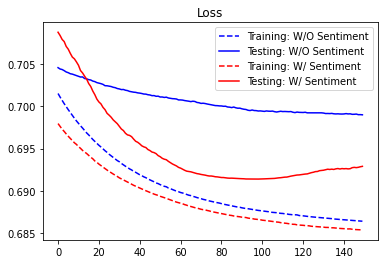

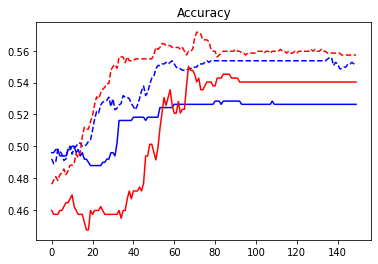

In [16]:
plt.title("Loss", loc='center')
plt.plot(r.history['loss'], 'b--', label="Training: W/O Sentiment")
plt.plot(r.history['val_loss'], 'b', label='Testing: W/O Sentiment')
plt.plot(r_sent.history['loss'], 'r--', label="Training: W/ Sentiment")
plt.plot(r_sent.history['val_loss'], 'r', label='Testing: W/ Sentiment')
plt.legend()
plt.show()

plt.title("Accuracy", loc='center')
plt.plot(r.history['accuracy'], 'b--', label="Training: W/O Sentiment")
plt.plot(r.history['val_accuracy'], 'b', label='Testing: W/O Sentiment')
plt.plot(r_sent.history['accuracy'], 'r--', label="Training: W/ Sentiment")
plt.plot(r_sent.history['val_accuracy'], 'r', label='Testing: W/ Sentiment')
# plt.legend()
plt.show()